In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_valid = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=1000,
                                          shuffle=True,
                                          num_workers=4)
dataloader_valid = utils.data.DataLoader(dataset_valid,
                                          batch_size=1000,
                                          shuffle=True,
                                          num_workers=4)

In [4]:
device = 'cuda'

class VAE(nn.Module):
    def __init__(self, z_dim):
      super(VAE, self).__init__()
      self.dense_enc1 = nn.Linear(28*28, 200)
      self.dense_enc2 = nn.Linear(200, 200)
      self.dense_encmean = nn.Linear(200, z_dim)
      self.dense_encvar = nn.Linear(200, z_dim)
      self.dense_dec1 = nn.Linear(z_dim, 200)
      self.dense_dec2 = nn.Linear(200, 200)
      self.dense_dec3 = nn.Linear(200, 28*28)
    
    def _encoder(self, x):
      x = F.relu(self.dense_enc1(x))
      x = F.relu(self.dense_enc2(x))
      mean = self.dense_encmean(x)
      var = F.softplus(self.dense_encvar(x))
      return mean, var
    
    def _sample_z(self, mean, var):
      epsilon = torch.randn(mean.shape).to(device)
      return mean + torch.sqrt(var) * epsilon
 
    def _decoder(self, z):
      x = F.relu(self.dense_dec1(z))
      x = F.relu(self.dense_dec2(x))
      x = F.sigmoid(self.dense_dec3(x))
      return x

    def forward(self, x):
      mean, var = self._encoder(x)
      z = self._sample_z(mean, var)
      x = self._decoder(z)
      return x, z
    
    def loss(self, x):
      mean, var = self._encoder(x)
      KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
      z = self._sample_z(mean, var)
      y = self._decoder(z)
      reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y)))
      lower_bound = [-KL, reconstruction]                                      
      return -sum(lower_bound)

In [5]:
model = VAE(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for i in range(20):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      model.zero_grad()
      y = model(x)
      loss = model.loss(x)
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 0 loss: 270154.96875
EPOCH: 1 loss: 199830.265625
EPOCH: 2 loss: 188266.296875
EPOCH: 3 loss: 174755.34375
EPOCH: 4 loss: 158651.109375
EPOCH: 5 loss: 149229.25
EPOCH: 6 loss: 142372.1875
EPOCH: 7 loss: 137450.0625
EPOCH: 8 loss: 133197.09375
EPOCH: 9 loss: 130037.046875
EPOCH: 10 loss: 127779.1328125
EPOCH: 11 loss: 126051.421875
EPOCH: 12 loss: 124598.296875
EPOCH: 13 loss: 123428.5078125
EPOCH: 14 loss: 122338.1484375
EPOCH: 15 loss: 121392.5078125
EPOCH: 16 loss: 120418.7578125
EPOCH: 17 loss: 119392.1328125
EPOCH: 18 loss: 118497.0234375
EPOCH: 19 loss: 117649.34375


RuntimeError: size mismatch, m1: [1 x 100], m2: [10 x 200] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

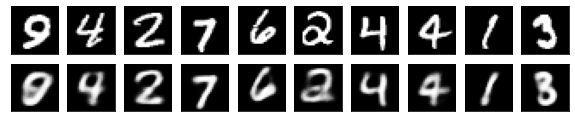

In [6]:
%matplotlib inline

fig = plt.figure(figsize=(10, 3))

model.eval()
zs = []
for x, t in dataloader_valid:
    # original
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    x = x.to(device)
    # generate from x
    y, z = model(x)
    zs.append(z)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    # generate from z
    z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)])
    y2 = model._decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break